# Goodreads Exploratory Data Analysis

- Author: Kevin Chuang (https://www.github.com/k-chuang)
- Date: 03/22/2019
- Description: Kaggle competition on the Goodreads dataset to develop a recommender system to recommend books to users.

**Overview and Assignment Goals**

The objective of this assignment is to help you develop a recommender system for an medium-sized dataset, to gain hands-on skills on data preparation and recommender system algorithms.

For this assignment, you are asked to predict the rating that a user will give to a book given their past book ratings. At the very minimum you can use only this information for your recommender system. However, you are also given access to additional data, including book metadata, timestamps etc. in case you'd like to use them as well for your analysis.

In [1]:
__author__ = 'Kevin Chuang (https://www.github.com/k-chuang)' 

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Utilities
import os
import shutil
import json

## Load data

In [2]:
train_csv = r"data/train.csv"
test_csv = r"data/test.csv"
submission_csv = r"data/sample_output.csv"
book_metadata_path = r"data/goodreads_books_children.json"

In [3]:
def process_book_metdata_to_df(metadata_path):
    book_metadata = open(metadata_path).read().splitlines()
    for i, x in enumerate(book_metadata):
        book_metadata[i] = json.loads(book_metadata[i])
    book_df = pd.DataFrame(book_metadata)
    return book_df

In [4]:
book_df = process_book_metdata_to_df(book_metadata_path)

In [5]:
train_df = pd.read_csv(train_csv, delimiter="\t")
test_df = pd.read_csv(test_csv, delimiter="\t")

## Analyze data

In [6]:
train_df.describe()

,user_id,book_id,rating
count,700000.000000,7.000000e+05,700000.000000
mean,18895.764374,4.970340e+06,2.644934
std,10745.949583,8.443227e+06,2.051200
min,0.000000,5.000000e+00,0.000000
25%,9558.000000,7.453200e+04,0.000000
50%,18986.000000,4.349280e+05,3.000000
75%,27946.000000,6.578293e+06,4.000000
max,37230.000000,3.645941e+07,5.000000


In [9]:
# Look for duplicated data

train_df[train_df.duplicated(subset=['user_id','book_id'], keep=False)].groupby(['user_id', 'book_id']).count()

rating
user_id book_id         
24      113946         2
        196283         2
        15944573       2
        18874096       2
56      20172134       2
83      77392          2
128     8663303        2
280     272447         2
389     24178          2
487     794230         2
494     478356         2
784     29212271       2
        32819894       2
801     34456738       2
972     22292490       2
1023    6340266        2
1029    145383         2
1259    116591         2
        123805         2
        762677         2
        1322450        2
        1456733        2
        2740568        2
        9953257        2
1379    28250985       2
1427    28195          2
1468    10365          2
        19321          2
        38709          2
        44186          2
...                  ...
36568   31319741       2
36636   15794580       2
        20786366       2
        21855274       2
        22609279       2
        22609855       2
        22864855       2
        23068261       2
        23200486       2
        23217710       2
        23310695       2
        24855325       2
        30962057       2
        33509392       2
        34525408       2
36704   33113315       2
        33158535       2
        34220851       2
        36314263       2
36754   742272         2
36760   878243         2
36996   23720749       2
37040   3843308        2
        21965059       2
37107   1535111        2
        10637959       2
37210   28450988       2
        30079758       2
        31707318       2
        34314454       2

[969 rows x 1 columns]

In [10]:
# There are 1938/2 = 969 pairs of duplicates
print(train_df[train_df.duplicated(subset=['user_id','book_id'], keep=False)].groupby(['user_id', 'book_id']).count().shape)
train_df[train_df.duplicated(subset=['user_id','book_id'], keep=False)].shape

(969, 1)


(1938, 3)

In [11]:
# drop duplicates
train_df.drop_duplicates(subset=['user_id','book_id'], keep='first', inplace=True)

In [12]:
# Check shape, should be 700,000 - 969 = 699031
assert len(train_df) == 699031

In [13]:
train_books = np.unique(train_df['book_id'])
test_books = np.unique(test_df['book_id'])

print("Number of unique books in training set: {}".format(len(train_books)))
print("Number of unique books in test set: {}".format(len(test_books)))
print("Number of non-intersecting train books and test books: {}".format(len(set(list(train_books)).symmetric_difference(set(list(test_books))))))
# print("Number of non-intersecting train books in test set: {}".format(np.setdiff1d(train_books, test_books).shape[0]))
print("Number of unique books in both train and test set: {}".format(np.unique(np.concatenate((train_books, test_books))).shape[0]))

Number of unique books in training set: 68371
Number of unique books in test set: 47672
Number of non-intersecting train books and test books: 39501
Number of unique books in both train and test set: 77772


In [14]:
print("Distinct values of ratings: {}".format(np.unique(train_df['rating'])))

Distinct values of ratings: [0 1 2 3 4 5]


In [15]:
tmp1 = train_df.groupby("user_id")['user_id'].count().min()
tmp2 = train_df.groupby("book_id")['book_id'].count().min()
print('For the users that rated books and the books that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per book is {}'.format(tmp2))

For the users that rated books and the books that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per book is 1


In [16]:
book_count = sum(train_df.groupby(["book_id"])["book_id"].count() == 1)

print('{} out of {} books are rated by only one user'.format(book_count, len(train_books)))

25899 out of 68371 books are rated by only one user


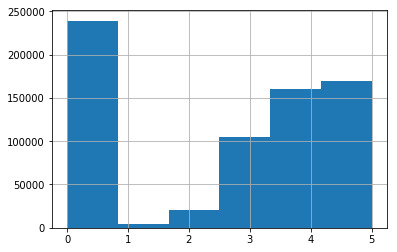

In [17]:
# Plot histogram of ratings
train_df.rating.hist( bins = 6 )

In [18]:
print("Number of 0 ratings: {}".format(train_df[train_df['rating'] == 0].shape[0]))
print("Number of 1 ratings: {}".format(train_df[train_df['rating'] == 1].shape[0]))
print("Number of 2 ratings: {}".format(train_df[train_df['rating'] == 2].shape[0]))
print("Number of 3 ratings: {}".format(train_df[train_df['rating'] == 3].shape[0]))
print("Number of 4 ratings: {}".format(train_df[train_df['rating'] == 4].shape[0]))
print("Number of 5 ratings: {}".format(train_df[train_df['rating'] == 5].shape[0]))

Number of 0 ratings: 239026
Number of 1 ratings: 4443
Number of 2 ratings: 20821
Number of 3 ratings: 105017
Number of 4 ratings: 160219
Number of 5 ratings: 169505


**There are a lot of "0" ratings, and relatively low "1" and "2" ratings.**

### Reviews per book

Most books have few ratings (1-5 ratings).

In [19]:
# Reviews per book
reviews_per_book = train_df.groupby( 'book_id' ).book_id.apply( lambda x: len( x ))
reviews_per_book.describe()

count    68371.000000
mean        10.224086
std         93.950140
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      11204.000000
Name: book_id, dtype: float64

### Reviews per user

Most users have few ratings (1-16 ratings).

In [20]:
reviews_per_user = train_df.groupby( 'user_id' ).user_id.apply( lambda x: len( x ))
reviews_per_user.describe()

count    35280.000000
mean        19.813804
std         70.318794
min          1.000000
25%          2.000000
50%          6.000000
75%         16.000000
max       4287.000000
Name: user_id, dtype: float64

## Book Metadata 

- There are multiple languages, not just English
- There are missing descriptions of books, and also the descriptions contain html tags.
- There are multiple authors per book (illustrators)
- Potentially important columns to use for analysis:
    - `description`, `average_rating`, `authors`, `popular_shelves`, `ratings_count`, `num_pages`, `text_reviews_count`
- Get book title from url?
- Use NLP to process book titles and descriptions using basic BoW

In [21]:
book_df.head(2)

,asin,authors,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,...,publication_day,publication_month,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,url,work_id
0,,"[{'author_id': '3041852', 'role': ''}]",4.13,287141,US,"Relates in vigorous prose the tale of Aeneas, ...",,Paperback,https://s.gr-assets.com/assets/nophoto/book/11...,false,...,13,9,2006,Yesterday's Classics,46,[],[],7,https://www.goodreads.com/book/show/287141.The...,278578
1,,"[{'author_id': '19158', 'role': ''}]",4.22,6066812,US,"<br /><p>To Kara's astonishment, she discovers...",,Paperback,https://images.gr-assets.com/books/1316637798m...,false,...,3,3,2009,Seven Seas,98,[s151854],"[948696, 439885, 274955, 12978730, 372986, 216...",6,https://www.goodreads.com/book/show/6066812-al...,701117


In [22]:
print(book_df.columns)

Index(['asin', 'authors', 'average_rating', 'book_id', 'country_code',
       'description', 'edition_information', 'format', 'image_url', 'is_ebook',
       'isbn', 'isbn13', 'kindle_asin', 'language_code', 'link', 'num_pages',
       'popular_shelves', 'publication_day', 'publication_month',
       'publication_year', 'publisher', 'ratings_count', 'series',
       'similar_books', 'text_reviews_count', 'url', 'work_id'],
      dtype='object')


In [23]:
book_df['average_rating'] = book_df['average_rating'].astype(float)
book_df['ratings_count'] = book_df['ratings_count'].astype(int)
book_df['text_reviews_count'] = book_df['text_reviews_count'].astype(int)

### Average rating column

In [24]:
book_df['average_rating'].describe()

count    124082.000000
mean          3.910883
std           0.364855
min           0.000000
25%           3.710000
50%           3.940000
75%           4.140000
max           5.000000
Name: average_rating, dtype: float64

In [25]:
print("Number of books with 0 rating: {}".format(len(book_df[book_df['average_rating'] == 0])))
print("Number of books with 5 rating: {}".format(len(book_df[book_df['average_rating'] == 5])))

Number of books with 0 rating: 23
Number of books with 5 rating: 393


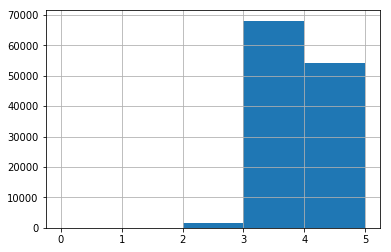

In [26]:
book_df['average_rating'].hist(bins=5)

### Ratings count column

In [27]:
book_df['ratings_count'].describe()

count    1.240820e+05
mean     5.228165e+02
std      1.083869e+04
min      0.000000e+00
25%      1.000000e+01
50%      3.000000e+01
75%      9.600000e+01
max      1.876252e+06
Name: ratings_count, dtype: float64

### Text reviews count column

In [28]:
book_df['text_reviews_count'].describe()

count    124082.000000
mean         27.086209
std         266.547028
min           0.000000
25%           2.000000
50%           5.000000
75%          15.000000
max       49850.000000
Name: text_reviews_count, dtype: float64

### Book IDs

In [29]:
book_df['book_id'] = book_df['book_id'].astype(int)

In [30]:
book_df_ids = np.unique(book_df['book_id'].values)

In [31]:
print("Number of unique books in metadata: {}".format(len(book_df_ids)))

Number of unique books in metadata: 124082


In [32]:
print("Number of non-intersecting books in metadata not contained in train data: {}".format(
    np.setdiff1d(train_books, book_df_ids).shape[0]))

print("Number of non-intersecting books in metadata not contained in test data: {}".format(
    np.setdiff1d(test_books, book_df_ids).shape[0]))

Number of non-intersecting books in metadata not contained in train data: 0
Number of non-intersecting books in metadata not contained in test data: 0


### Work IDs

- Just to check if whether book_id or work_id in book metadata map to the train/test sets

In [33]:
book_df['work_id'] = book_df['work_id'].astype(int)

In [34]:
book_df_work_ids = np.unique(book_df['work_id'].values)

In [35]:
print("Number of non-intersecting books in metadata not contained in train data: {}".format(
    np.setdiff1d(train_books, book_df_work_ids).shape[0]))

print("Number of non-intersecting books in metadata not contained in test data: {}".format(
    np.setdiff1d(test_books, book_df_work_ids).shape[0]))

Number of non-intersecting books in metadata not contained in train data: 67865
Number of non-intersecting books in metadata not contained in test data: 47323
